
================ Computation Time ================
Ground Truth (F + derivs)         : 0.005993 s
FD (derivs from grid)             : 0.000722 s
B-Spline (derivs ONLY)            : 0.000443 s
B-Spline (basis build)            : 0.322953 s
B-Spline (fit only)               : 0.112318 s

================ Quantitative Errors (interior) ================

$s$
--------------------------------------------------------------------------------------
Method               MeanAbs        MaxAbs          RMSE         RelL2
--------------------------------------------------------------------------------------
Ground Truth       0.000e+00     0.000e+00     0.000e+00     0.000e+00
B-Spline           2.566e-05     8.035e-05     3.169e-05     6.344e-05
FD                 0.000e+00     0.000e+00     0.000e+00     0.000e+00

$s_t$
--------------------------------------------------------------------------------------
Method               MeanAbs        MaxAbs          RMSE         RelL2
-------------------

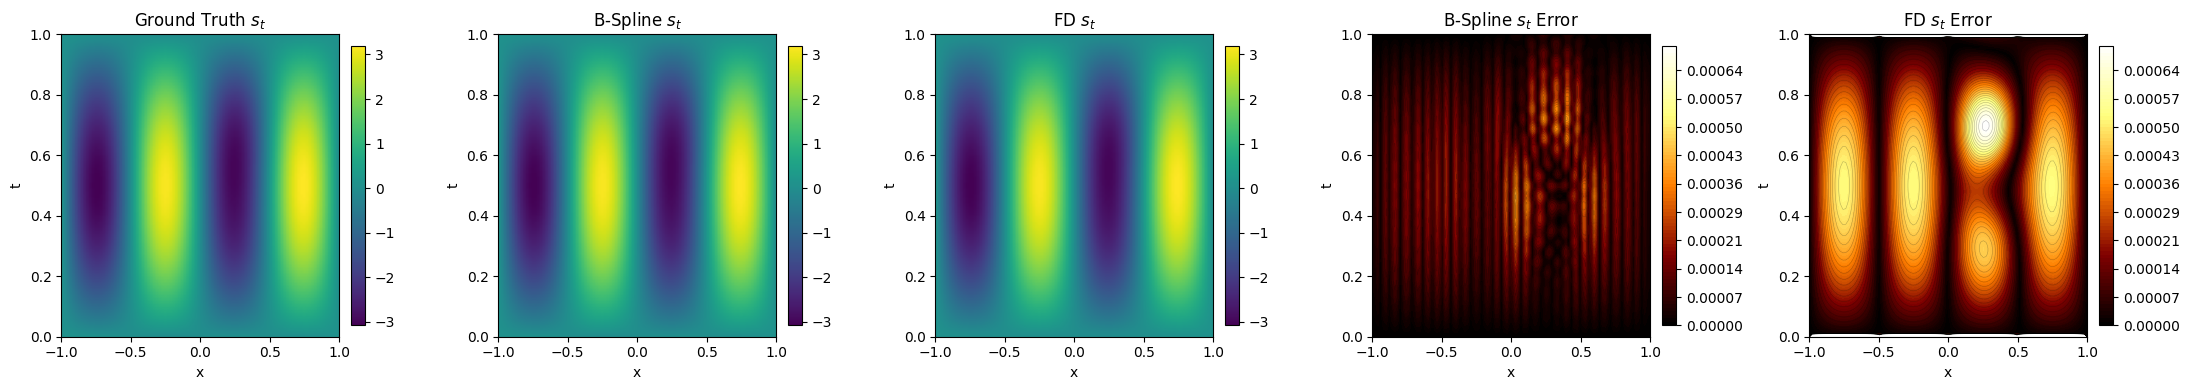

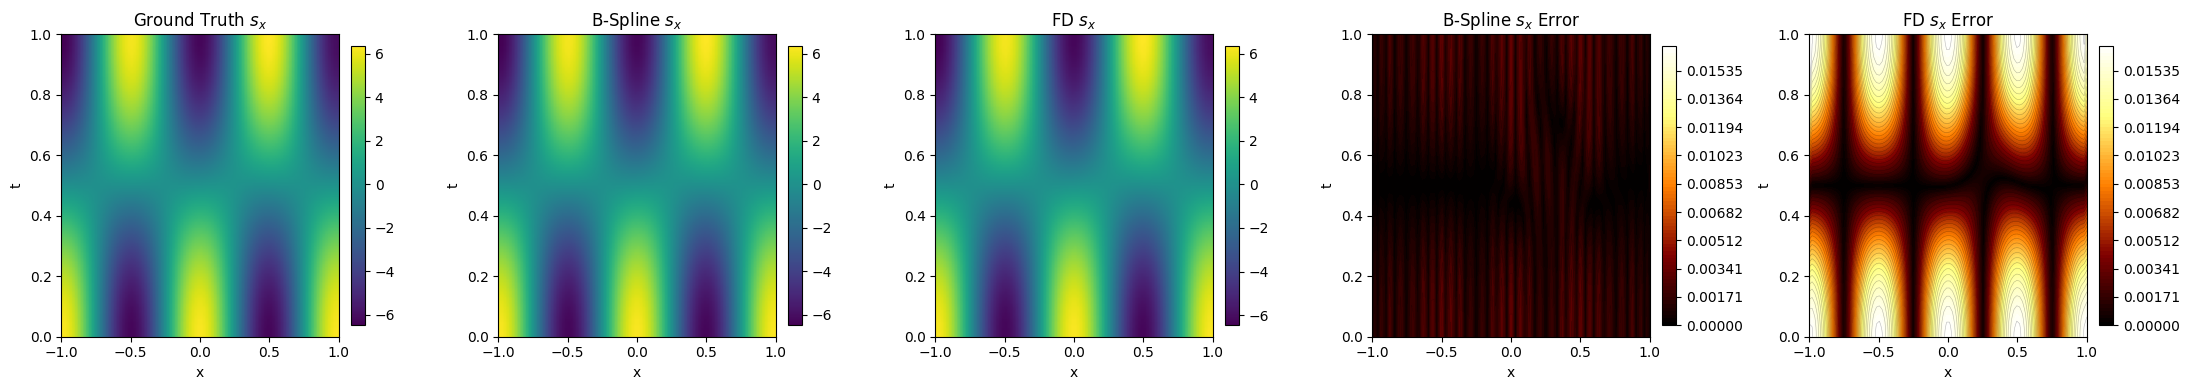

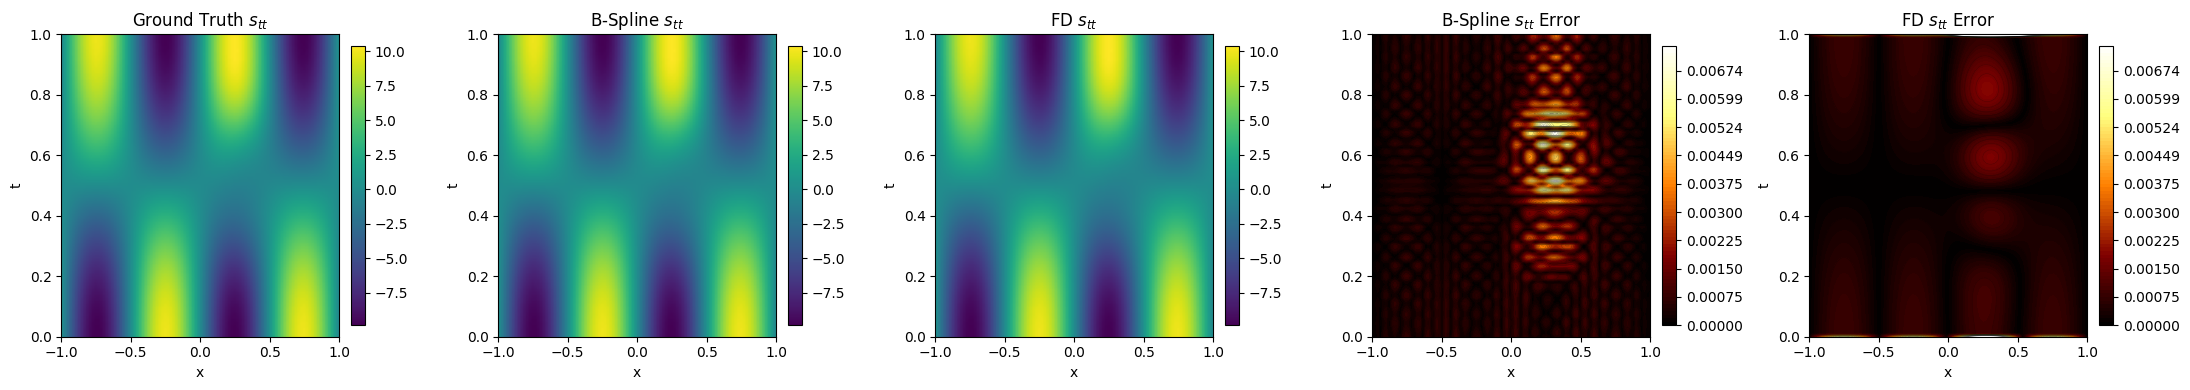

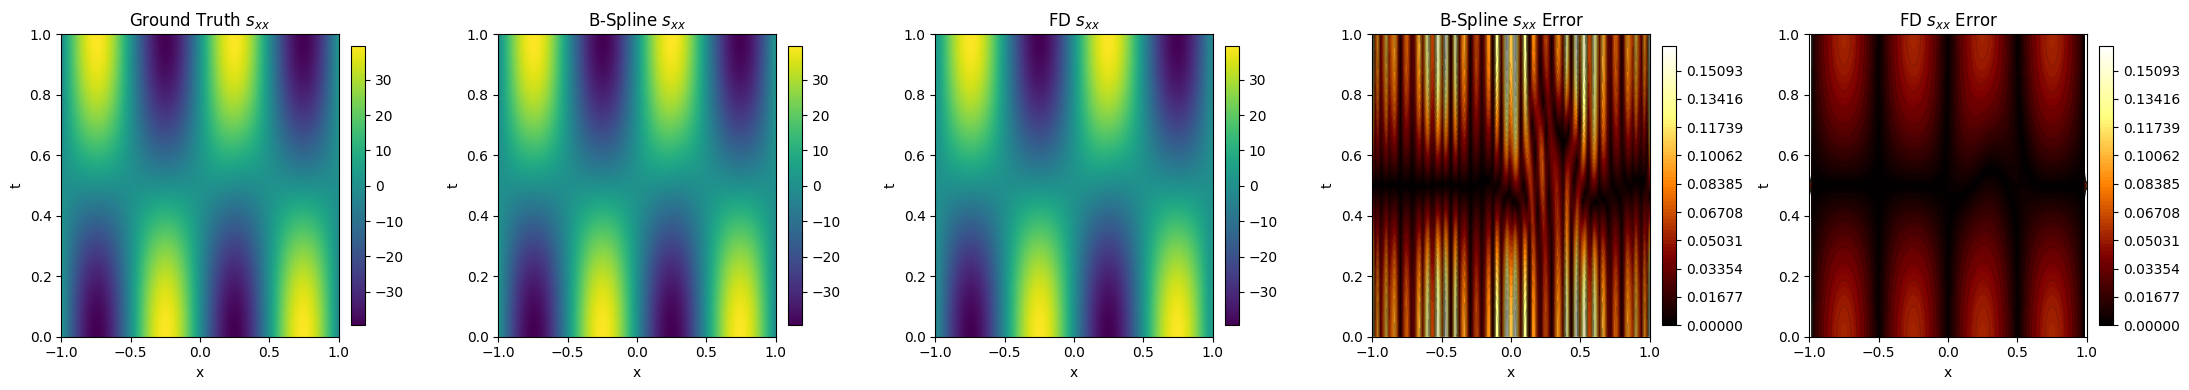

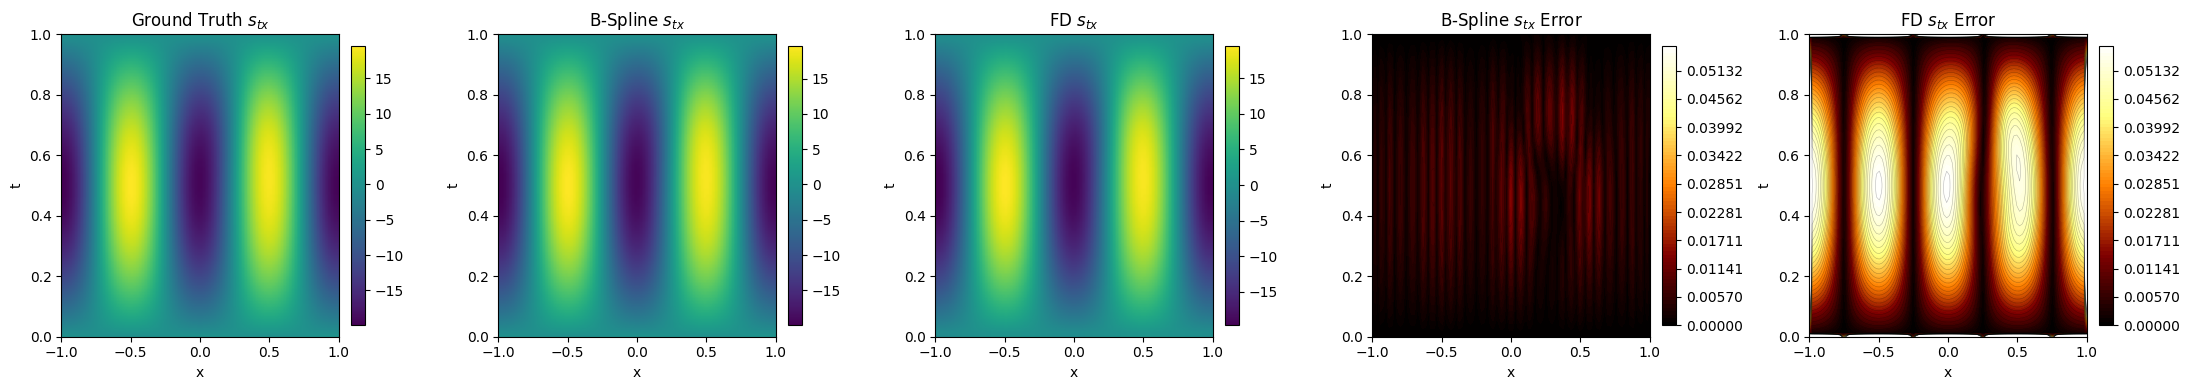

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.ticker import FormatStrFormatter


# ============================================================
# 1) B-spline basis utilities (your style)
# ============================================================
def BsFun(i, d, t, Ln):
    if d == 0:
        return 1.0 if (Ln[i] <= t < Ln[i + 1]) else 0.0
    den1 = Ln[d + i] - Ln[i]
    den2 = Ln[d + i + 1] - Ln[i + 1]
    a = 0.0 if den1 == 0 else (t - Ln[i]) / den1
    b = 0.0 if den2 == 0 else (Ln[d + i + 1] - t) / den2
    return a * BsFun(i, d - 1, t, Ln) + b * BsFun(i + 1, d - 1, t, Ln)

def BsFun_derivative(i, d, t, Ln):
    if d == 0:
        return 0.0
    den1 = Ln[d + i] - Ln[i]
    den2 = Ln[d + i + 1] - Ln[i + 1]
    a = 0.0 if den1 == 0 else d / den1
    b = 0.0 if den2 == 0 else d / den2
    return a * BsFun(i, d - 1, t, Ln) - b * BsFun(i + 1, d - 1, t, Ln)

def BsFun_second_derivative(i, d, t, Ln):
    if d < 2:
        return 0.0
    den1 = Ln[d + i] - Ln[i]
    den2 = Ln[d + i + 1] - Ln[i + 1]
    a = 0.0 if den1 == 0 else d / den1
    b = 0.0 if den2 == 0 else d / den2
    return a * BsFun_derivative(i, d - 1, t, Ln) - b * BsFun_derivative(i + 1, d - 1, t, Ln)

def BsKnots(n_cp, d, Ns):
    """
    Uniform clamped knots in "index space" tau.
    tau ranges from 0 to Ln[-1] = n_cp - d.
    """
    n_knots = n_cp + d + 1
    Ln = np.zeros(n_knots, dtype=float)

    for i in range(d + 1, n_knots - d - 1):
        Ln[i] = i - d
    Ln[n_knots - d - 1 :] = n_cp - d

    tk = np.zeros(Ns, dtype=float)
    for i in range(1, Ns):
        tk[i] = tk[i - 1] + Ln[-1] / (Ns - 1)

    Bit = np.zeros((Ns, n_cp), dtype=float)
    for j in range(n_cp):
        for i in range(Ns):
            Bit[i, j] = BsFun(j, d, tk[i], Ln)

    Bit[Ns - 1, n_cp - 1] = 1.0  # clamp endpoint
    return tk, Ln, Bit

def BsKnots_derivatives(n_cp, d, Ns, Ln, tk):
    Bit_d1 = np.zeros((Ns, n_cp), dtype=float)
    Bit_d2 = np.zeros((Ns, n_cp), dtype=float)
    for j in range(n_cp):
        for i in range(Ns):
            Bit_d1[i, j] = BsFun_derivative(j, d, tk[i], Ln)
            Bit_d2[i, j] = BsFun_second_derivative(j, d, tk[i], Ln)
    return Bit_d1, Bit_d2

# ============================================================
# 2) Smooth 2D surface with analytic grad + Hessian
# ============================================================
def F_true(t, x):
    return (
        np.sin(2*np.pi*x) * np.cos(np.pi*t)
        + 0.1*(x**2)*t
        + 0.05*np.exp(-((x-0.3)**2 + (t-0.6)**2)/0.05)
    )

def dF_dt(t, x):
    term1 = np.sin(2*np.pi*x) * (-np.pi) * np.sin(np.pi*t)
    term2 = 0.1*(x**2)
    E = np.exp(-((x-0.3)**2 + (t-0.6)**2)/0.05)
    term3 = 0.05 * E * (-(2*(t-0.6))/0.05)
    return term1 + term2 + term3

def dF_dx(t, x):
    term1 = (2*np.pi)*np.cos(2*np.pi*x) * np.cos(np.pi*t)
    term2 = 0.2*x*t
    E = np.exp(-((x-0.3)**2 + (t-0.6)**2)/0.05)
    term3 = 0.05 * E * (-(2*(x-0.3))/0.05)
    return term1 + term2 + term3

def d2F_dtt(t, x):
    term1 = np.sin(2*np.pi*x) * (-(np.pi**2)) * np.cos(np.pi*t)
    E = np.exp(-((x-0.3)**2 + (t-0.6)**2)/0.05)
    a = (-(2*(t-0.6))/0.05)
    E2 = E * (-(2/0.05) + a*a)
    term3 = 0.05 * E2
    return term1 + term3

def d2F_dxx(t, x):
    term1 = (-(2*np.pi)**2) * np.sin(2*np.pi*x) * np.cos(np.pi*t)
    term2 = 0.2*t
    E = np.exp(-((x-0.3)**2 + (t-0.6)**2)/0.05)
    a = (-(2*(x-0.3))/0.05)
    E2 = E * (-(2/0.05) + a*a)
    term3 = 0.05 * E2
    return term1 + term2 + term3

def d2F_dtx(t, x):
    term1 = (2*np.pi)*np.cos(2*np.pi*x) * (-np.pi) * np.sin(np.pi*t)
    term2 = 0.2*x
    E = np.exp(-((x-0.3)**2 + (t-0.6)**2)/0.05)
    a_t = (-(2*(t-0.6))/0.05)
    E_x = E * (-(2*(x-0.3))/0.05)
    term3 = 0.05 * (E_x * a_t)
    return term1 + term2 + term3

# ============================================================
# 3) Fit B-spline surface by least squares
# ============================================================
def fit_bspline_surface(F_samples, Bit_t, Bit_x, ridge=1e-10):
    """
    Solve F ≈ Bit_t @ U @ Bit_x^T by LS:
    vec(F) = (Bit_x ⊗ Bit_t) vec(U)
    """
    n_cp_t = Bit_t.shape[1]
    n_cp_x = Bit_x.shape[1]
    A = np.kron(Bit_x, Bit_t)
    b = F_samples.reshape(-1, order="C")

    ATA = A.T @ A + ridge*np.eye(n_cp_t*n_cp_x)
    ATb = A.T @ b
    vecU = np.linalg.solve(ATA, ATb)
    U = vecU.reshape((n_cp_t, n_cp_x), order="C")
    return U

# ============================================================
# 4) Finite difference derivatives on grid
# ============================================================
def finite_difference_derivatives(F, t, x):
    dt = t[1] - t[0]
    dx = x[1] - x[0]

    Ft  = np.zeros_like(F)
    Fx  = np.zeros_like(F)
    Ftt = np.zeros_like(F)
    Fxx = np.zeros_like(F)
    Ftx = np.zeros_like(F)

    Ft[1:-1, :] = (F[2:, :] - F[:-2, :]) / (2*dt)
    Ft[0, :]    = (F[1, :] - F[0, :]) / dt
    Ft[-1, :]   = (F[-1, :] - F[-2, :]) / dt

    Fx[:, 1:-1] = (F[:, 2:] - F[:, :-2]) / (2*dx)
    Fx[:, 0]    = (F[:, 1] - F[:, 0]) / dx
    Fx[:, -1]   = (F[:, -1] - F[:, -2]) / dx

    Ftt[1:-1, :] = (F[2:, :] - 2*F[1:-1, :] + F[:-2, :]) / (dt*dt)
    Ftt[0, :]    = Ftt[1, :]
    Ftt[-1, :]   = Ftt[-2, :]

    Fxx[:, 1:-1] = (F[:, 2:] - 2*F[:, 1:-1] + F[:, :-2]) / (dx*dx)
    Fxx[:, 0]    = Fxx[:, 1]
    Fxx[:, -1]   = Fxx[:, -2]

    Ftx[1:-1, 1:-1] = (F[2:, 2:] - F[2:, :-2] - F[:-2, 2:] + F[:-2, :-2]) / (4*dt*dx)
    Ftx[0, :]  = Ftx[1, :]
    Ftx[-1, :] = Ftx[-2, :]
    Ftx[:, 0]  = Ftx[:, 1]
    Ftx[:, -1] = Ftx[:, -2]

    return Ft, Fx, Ftt, Fxx, Ftx

# ============================================================
# 5) Metrics + plotting helpers
# ============================================================
def rel_l2(pred, gt, mask):
    num = np.linalg.norm((pred - gt)[mask])
    den = np.linalg.norm(gt[mask])
    return num / (den + 1e-12)

def summarize_metrics(name_latex, gt, bs, fd, mask):
    def stats(arr):
        diff = (arr - gt)[mask]
        mean_abs = np.mean(np.abs(diff))
        max_abs  = np.max(np.abs(diff))
        rmse     = np.sqrt(np.mean(diff**2))
        rel      = rel_l2(arr, gt, mask)
        return mean_abs, max_abs, rmse, rel

    bs_mean, bs_max, bs_rmse, bs_rel = stats(bs)
    fd_mean, fd_max, fd_rmse, fd_rel = stats(fd)

    print(f"\n{name_latex}")
    print("-"*86)
    print(f"{'Method':<14}{'MeanAbs':>14}{'MaxAbs':>14}{'RMSE':>14}{'RelL2':>14}")
    print("-"*86)
    print(f"{'Ground Truth':<14}{0.0:14.3e}{0.0:14.3e}{0.0:14.3e}{0.0:14.3e}")
    print(f"{'B-Spline':<14}{bs_mean:14.3e}{bs_max:14.3e}{bs_rmse:14.3e}{bs_rel:14.3e}")
    print(f"{'FD':<14}{fd_mean:14.3e}{fd_max:14.3e}{fd_rmse:14.3e}{fd_rel:14.3e}")

def value_imshow(ax, Z, title, t, x, cmap="viridis", vmin=None, vmax=None):
    im = ax.imshow(
        Z,
        origin="lower",
        aspect="auto",
        extent=[x.min(), x.max(), t.min(), t.max()],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
    )
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    return im

def error_difference_heatmap(ax, E, title, t, x, vmin, vmax,
                             levels=60, cmap="afmhot",
                             line_alpha=0.28, line_width=0.4):
    """
    Error heatmap styled like your screenshot:
    - filled contours with many levels (banded look)
    - contour lines
    """
    X, T = np.meshgrid(x, t)
    levs = np.linspace(vmin, vmax, levels)

    cf = ax.contourf(X, T, E, levels=levs, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.contour(X, T, E, levels=levs[::3], colors="k", linewidths=line_width, alpha=line_alpha)

    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    return cf

def plot_quantity_row(q_latex, gt, bs, fd, t, x, mask,
                      value_cmap="viridis",
                      error_cmap="afmhot",
                      error_levels=60):
    """
    5 panels:
    [Ground Truth] [B-Spline] [FD] [B-Spline Error] [FD Error]
    Error plots:
      - same range for BS vs FD (same vmin/vmax)
      - NOT shared colorbar (each has its own)
      - contourf-based "Difference" look
    """
    err_bs = np.abs(bs - gt)
    err_fd = np.abs(fd - gt)

    emin = 0.0
    emax = max(err_bs[mask].max(), err_fd[mask].max())

    fig, axs = plt.subplots(1, 5, figsize=(22, 4))

    im0 = value_imshow(axs[0], gt, f"Ground Truth {q_latex}", t, x, cmap=value_cmap)
    plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    im1 = value_imshow(axs[1], bs, f"B-Spline {q_latex}", t, x, cmap=value_cmap)
    plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    im2 = value_imshow(axs[2], fd, f"FD {q_latex}", t, x, cmap=value_cmap)
    plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    cf3 = error_difference_heatmap(
        axs[3], err_bs, f"B-Spline {q_latex} Error", t, x,
        vmin=emin, vmax=emax, levels=error_levels, cmap=error_cmap
    )
    # plt.colorbar(cf3, ax=axs[3], fraction=0.046, pad=0.04)
    cbar = plt.colorbar(cf3, ax=axs[3], fraction=0.046, pad=0.04)
    cbar.formatter = FormatStrFormatter('%.5f')  # or '%.4f'
    cbar.update_ticks()


    cf4 = error_difference_heatmap(
        axs[4], err_fd, f"FD {q_latex} Error", t, x,
        vmin=emin, vmax=emax, levels=error_levels, cmap=error_cmap
    )
    # plt.colorbar(cf4, ax=axs[4], fraction=0.046, pad=0.04)
    cbar = plt.colorbar(cf4, ax=axs[4], fraction=0.046, pad=0.04)
    cbar.formatter = FormatStrFormatter('%.5f')  # or '%.4f'
    cbar.update_ticks()

    plt.tight_layout()
    plt.show()

# ============================================================
# 6) Main
# ============================================================
if __name__ == "__main__":
    # ---------- domain ----------
    Tmax = 1.0
    x0, x1 = -1.0, 1.0
    Nt, Nx = 100, 100
    t = np.linspace(0.0, Tmax, Nt)
    x = np.linspace(x0, x1, Nx)
    TT, XX = np.meshgrid(t, x, indexing="ij")

    # ---------- interior mask (ignore 1-cell boundary for metrics/ranges) ----------
    mask = np.ones((Nt, Nx), dtype=bool)
    mask[[0, -1], :] = False
    mask[:, [0, -1]] = False

    # ============================================================
    # Ground Truth time (surface + derivatives)
    # ============================================================
    t0 = time.perf_counter()
    F_gt   = F_true(TT, XX)
    Ft_gt  = dF_dt(TT, XX)
    Fx_gt  = dF_dx(TT, XX)
    Ftt_gt = d2F_dtt(TT, XX)
    Fxx_gt = d2F_dxx(TT, XX)
    Ftx_gt = d2F_dtx(TT, XX)
    time_gt = time.perf_counter() - t0

    # ============================================================
    # B-Spline: basis build + fit + derivatives(only) timing breakdown
    # ============================================================
    n_cp_t, n_cp_x = 20, 20
    d = 4

    # (A) Build basis and derivative bases
    t0 = time.perf_counter()
    tk_t, Ln_t, Bit_t = BsKnots(n_cp_t, d, Nt)
    tk_x, Ln_x, Bit_x = BsKnots(n_cp_x, d, Nx)
    Bt1, Bt2 = BsKnots_derivatives(n_cp_t, d, Nt, Ln_t, tk_t)
    Bx1, Bx2 = BsKnots_derivatives(n_cp_x, d, Nx, Ln_x, tk_x)

    # scale tau-derivatives -> physical (t,x)
    tau_t_max = Ln_t[-1]  # = n_cp_t - d
    tau_x_max = Ln_x[-1]  # = n_cp_x - d
    alpha_t = (t.max() - t.min()) / tau_t_max
    alpha_x = (x.max() - x.min()) / tau_x_max

    Bt1_phys = Bt1 / alpha_t
    Bt2_phys = Bt2 / (alpha_t**2)
    Bx1_phys = Bx1 / alpha_x
    Bx2_phys = Bx2 / (alpha_x**2)
    time_bs_basis = time.perf_counter() - t0

    # (B) Fit time only
    t0 = time.perf_counter()
    U = fit_bspline_surface(F_gt, Bit_t, Bit_x, ridge=1e-10)
    time_bs_fit = time.perf_counter() - t0

    # (C) Derivative calculation time ONLY (given U + bases)
    t0 = time.perf_counter()
    # surface and derivatives
    F_bs   = Bit_t @ U @ Bit_x.T
    Ft_bs  = Bt1_phys @ U @ Bit_x.T
    Fx_bs  = Bit_t @ U @ Bx1_phys.T
    Ftt_bs = Bt2_phys @ U @ Bit_x.T
    Fxx_bs = Bit_t @ U @ Bx2_phys.T
    Ftx_bs = Bt1_phys @ U @ Bx1_phys.T
    time_bs_derivs_only = time.perf_counter() - t0

    # ============================================================
    # FD derivatives time (from sampled truth)
    # ============================================================
    t0 = time.perf_counter()
    Ft_fd, Fx_fd, Ftt_fd, Fxx_fd, Ftx_fd = finite_difference_derivatives(F_gt, t, x)
    time_fd = time.perf_counter() - t0

    # ============================================================
    # Time report (includes your requested B-Spline derivatives-only time)
    # ============================================================
    print("\n================ Computation Time ================")
    print(f"{'Ground Truth (F + derivs)':<34s}: {time_gt:.6f} s")
    print(f"{'FD (derivs from grid)':<34s}: {time_fd:.6f} s")
    print(f"{'B-Spline (derivs ONLY)':<34s}: {time_bs_derivs_only:.6f} s")
    # optional breakdown
    print(f"{'B-Spline (basis build)':<34s}: {time_bs_basis:.6f} s")
    print(f"{'B-Spline (fit only)':<34s}: {time_bs_fit:.6f} s")
    print("==================================================\n")

    # ============================================================
    # Quantitative errors (interior)
    # For F itself, FD doesn't apply; we print FD row as GT (zeros)
    # ============================================================
    print("================ Quantitative Errors (interior) ================")
    summarize_metrics(r"$s$",       F_gt,  F_bs,   F_gt,   mask)
    summarize_metrics(r"$s_t$",     Ft_gt, Ft_bs,  Ft_fd,  mask)
    summarize_metrics(r"$s_x$",     Fx_gt, Fx_bs,  Fx_fd,  mask)
    summarize_metrics(r"$s_{tt}$",  Ftt_gt, Ftt_bs, Ftt_fd, mask)
    summarize_metrics(r"$s_{xx}$",  Fxx_gt, Fxx_bs, Fxx_fd, mask)
    summarize_metrics(r"$s_{tx}$",  Ftx_gt, Ftx_bs, Ftx_fd, mask)
    print("================================================================\n")

    # ============================================================
    # Plots (5 panels each): GT / B-Spline / FD / BS Error / FD Error
    # Error panels use the "Difference-style" heatmap
    # ============================================================
    plot_quantity_row(r"$s_t$",     Ft_gt,  Ft_bs,  Ft_fd,  t, x, mask,
                      value_cmap="viridis", error_cmap="afmhot", error_levels=80)
    plot_quantity_row(r"$s_x$",     Fx_gt,  Fx_bs,  Fx_fd,  t, x, mask,
                      value_cmap="viridis", error_cmap="afmhot", error_levels=80)
    plot_quantity_row(r"$s_{tt}$",  Ftt_gt, Ftt_bs, Ftt_fd, t, x, mask,
                      value_cmap="viridis", error_cmap="afmhot", error_levels=80)
    plot_quantity_row(r"$s_{xx}$",  Fxx_gt, Fxx_bs, Fxx_fd, t, x, mask,
                      value_cmap="viridis", error_cmap="afmhot", error_levels=80)
    plot_quantity_row(r"$s_{tx}$",  Ftx_gt, Ftx_bs, Ftx_fd, t, x, mask,
                      value_cmap="viridis", error_cmap="afmhot", error_levels=80)



================ Computation Time ================
Ground Truth (F + derivs)         : 0.004769 s
FD (derivs from grid)             : 0.000750 s
B-Spline (derivs ONLY)            : 0.000563 s
B-Spline (basis build)            : 0.409011 s
B-Spline (fit only)               : 0.140819 s



/tmp/ipython-input-1464151874.py:297: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.95, wspace=0.05)


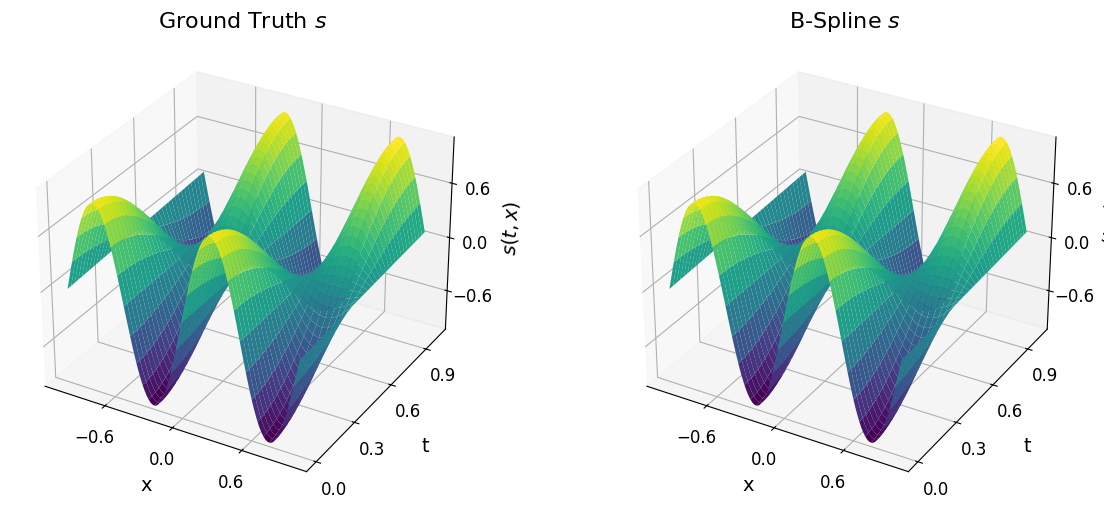

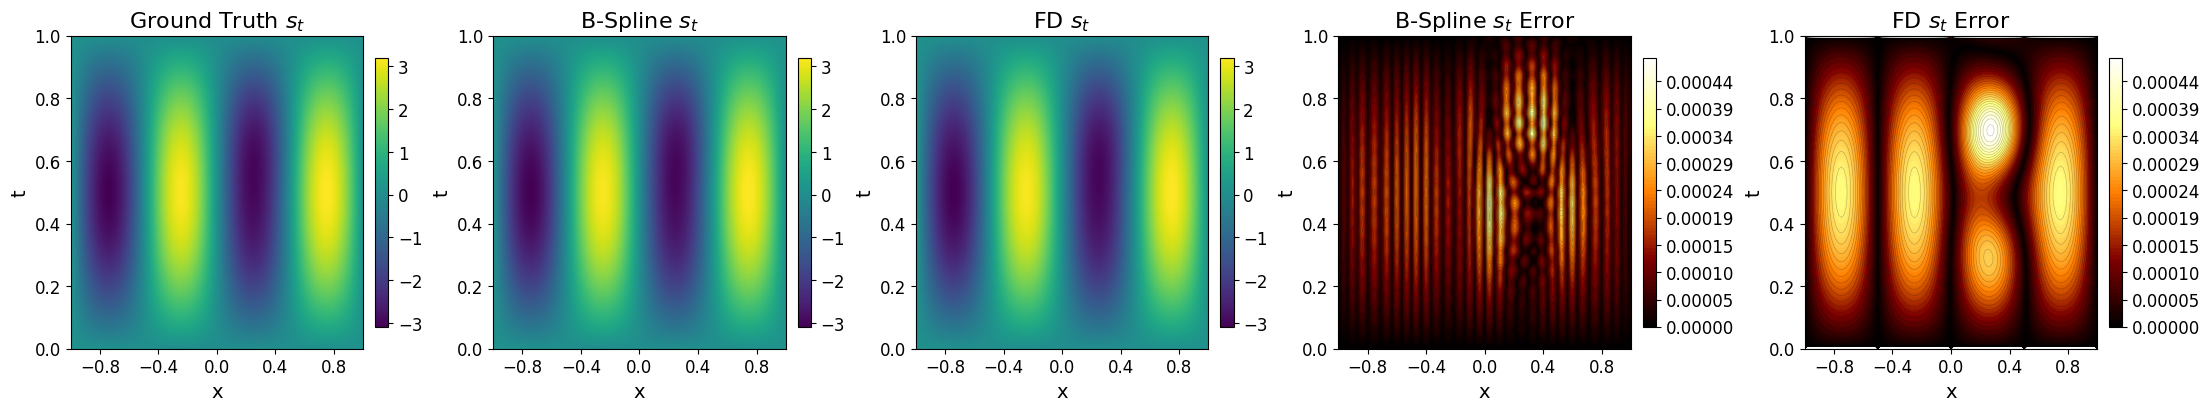

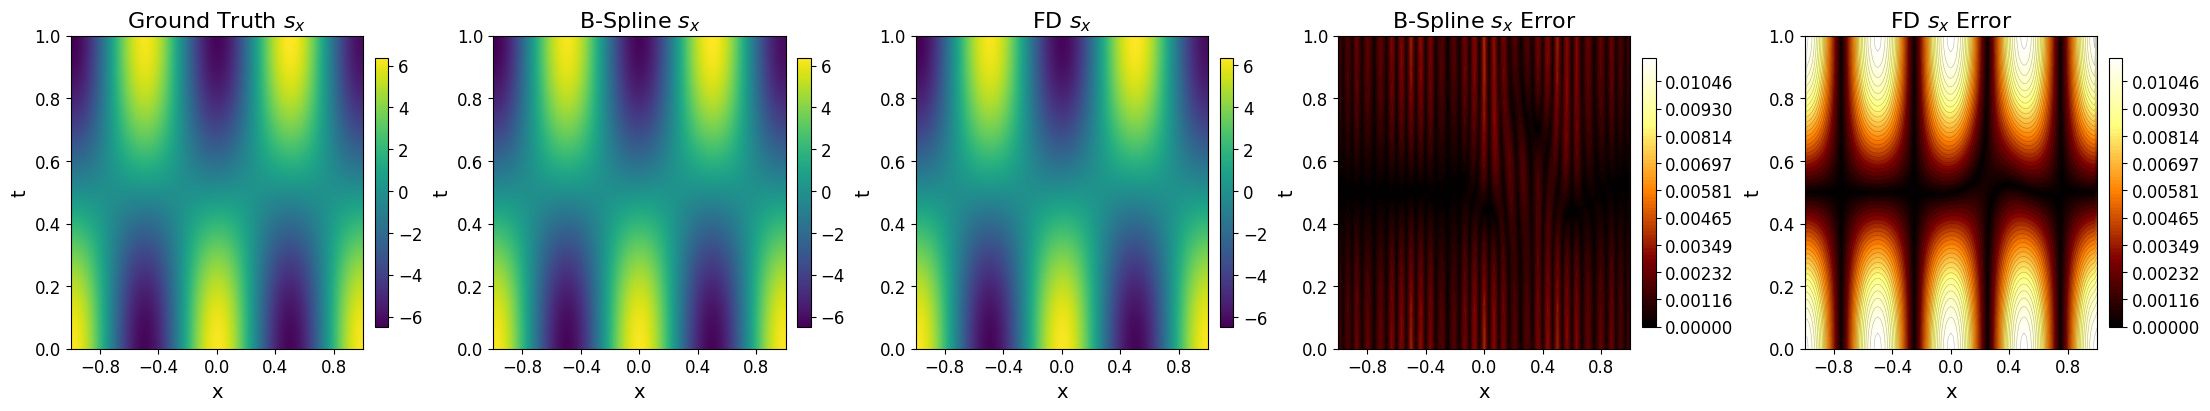

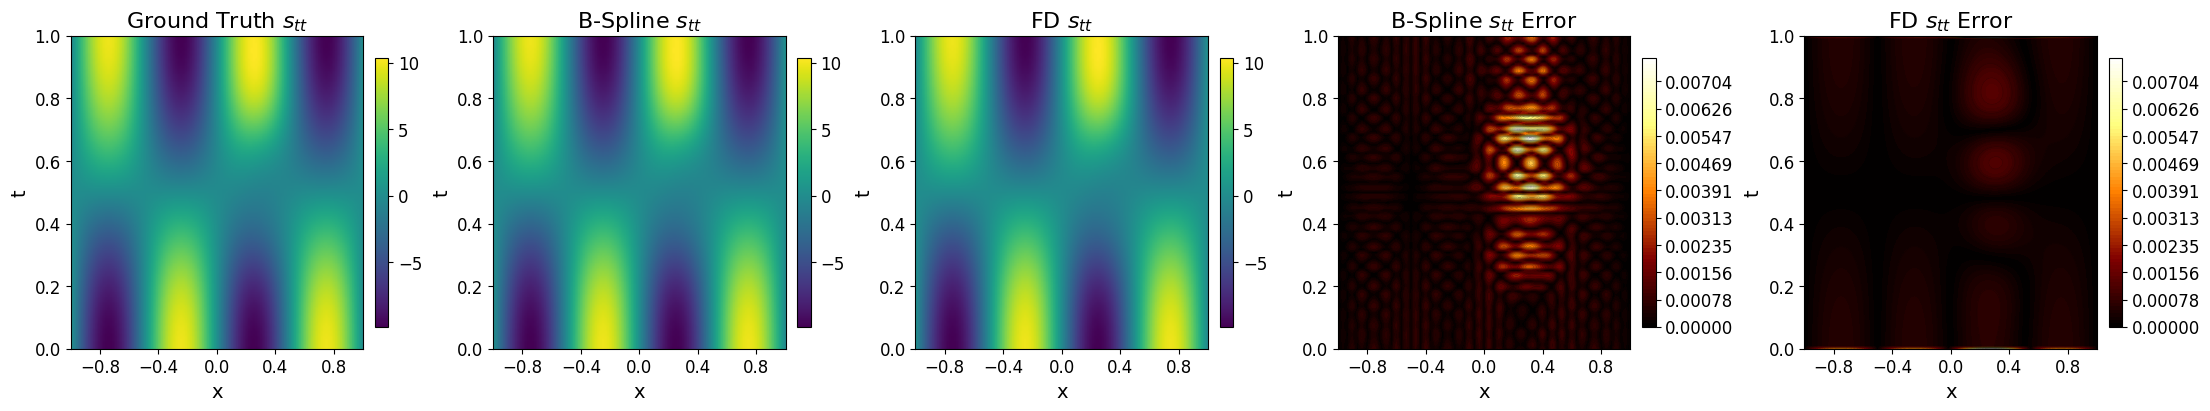

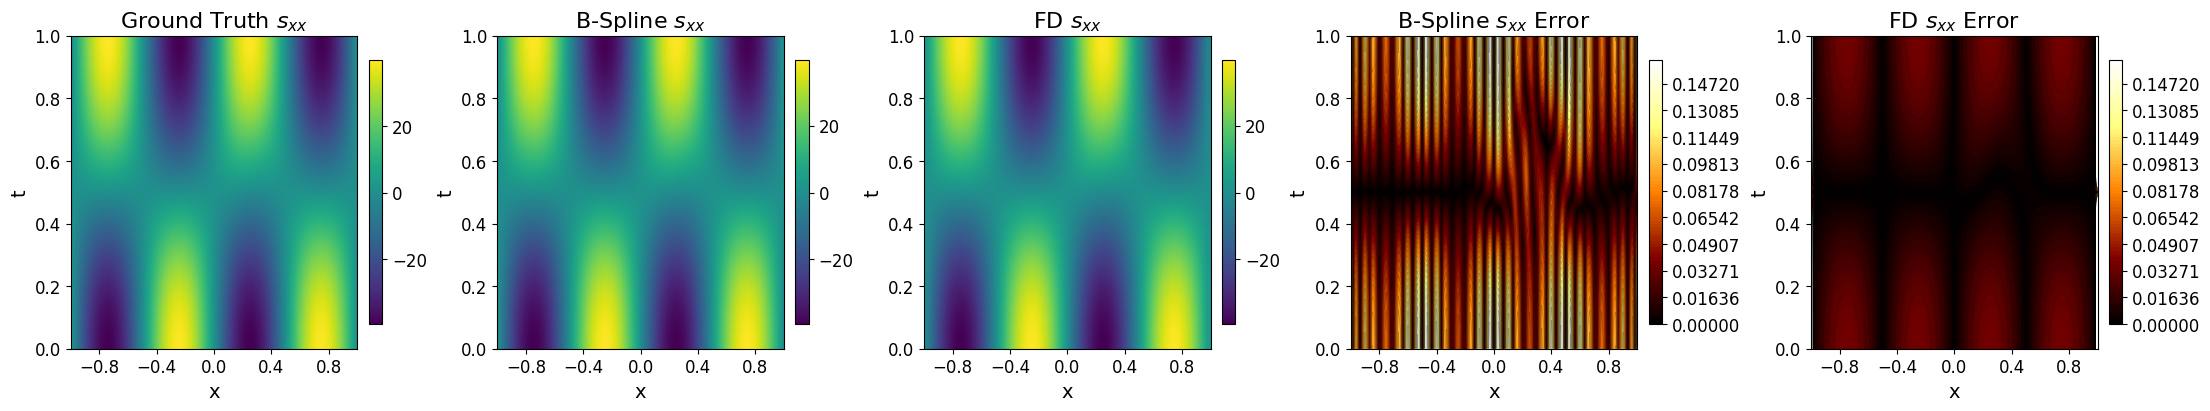

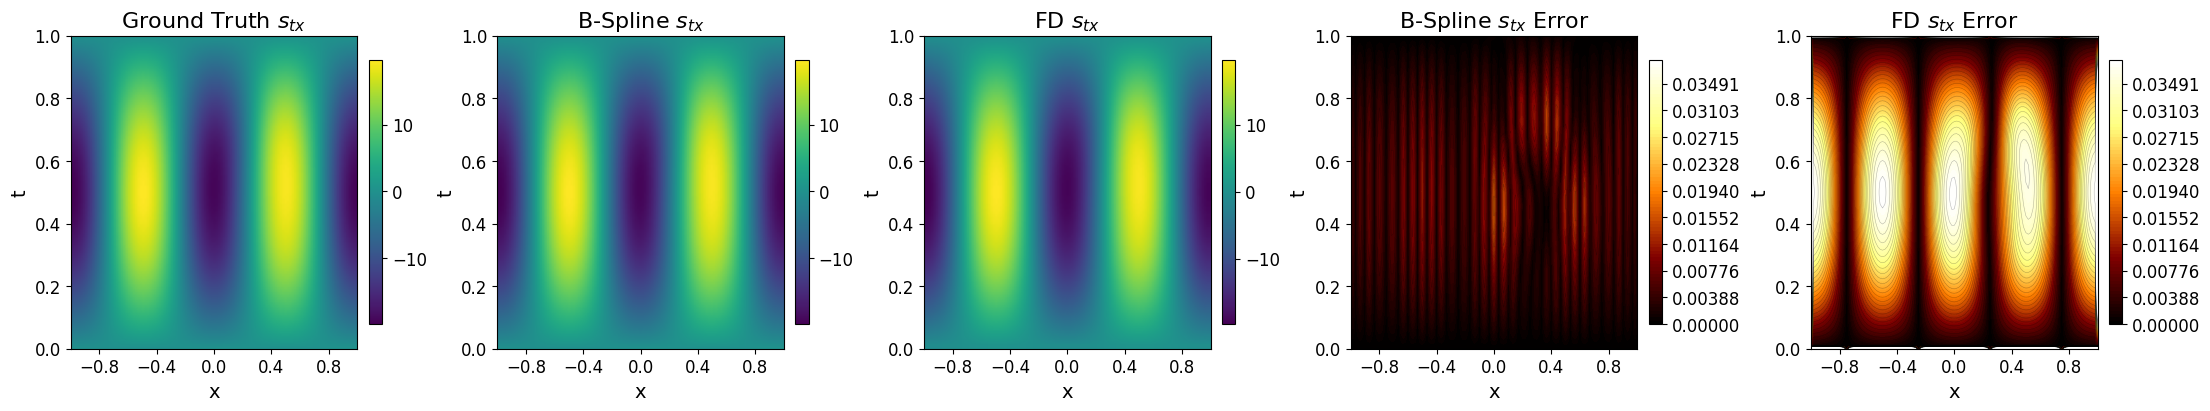

Saved all PNG figures to: bspline_fd_figs_png/


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ============================================================
# 0) Output folder + global plot style (PNG)
# ============================================================
save_dir = "bspline_fd_figs_png"
os.makedirs(save_dir, exist_ok=True)

# --- global font sizes (slightly larger) ---
FONT_TITLE = 16
FONT_LABEL = 14
FONT_TICK  = 12

plt.rcParams.update({
    "font.size": FONT_TICK,
    "axes.titlesize": FONT_TITLE,
    "axes.labelsize": FONT_LABEL,
    "xtick.labelsize": FONT_TICK,
    "ytick.labelsize": FONT_TICK,
})

# --- fewer ticks ---
N_TICKS_2D = 5
N_TICKS_3D = 4

# ============================================================
# 1) B-spline basis utilities (your style)
# ============================================================
def BsFun(i, d, t, Ln):
    if d == 0:
        return 1.0 if (Ln[i] <= t < Ln[i + 1]) else 0.0
    den1 = Ln[d + i] - Ln[i]
    den2 = Ln[d + i + 1] - Ln[i + 1]
    a = 0.0 if den1 == 0 else (t - Ln[i]) / den1
    b = 0.0 if den2 == 0 else (Ln[d + i + 1] - t) / den2
    return a * BsFun(i, d - 1, t, Ln) + b * BsFun(i + 1, d - 1, t, Ln)

def BsFun_derivative(i, d, t, Ln):
    if d == 0:
        return 0.0
    den1 = Ln[d + i] - Ln[i]
    den2 = Ln[d + i + 1] - Ln[i + 1]
    a = 0.0 if den1 == 0 else d / den1
    b = 0.0 if den2 == 0 else d / den2
    return a * BsFun(i, d - 1, t, Ln) - b * BsFun(i + 1, d - 1, t, Ln)

def BsFun_second_derivative(i, d, t, Ln):
    if d < 2:
        return 0.0
    den1 = Ln[d + i] - Ln[i]
    den2 = Ln[d + i + 1] - Ln[i + 1]
    a = 0.0 if den1 == 0 else d / den1
    b = 0.0 if den2 == 0 else d / den2
    return a * BsFun_derivative(i, d - 1, t, Ln) - b * BsFun_derivative(i + 1, d - 1, t, Ln)

def BsKnots(n_cp, d, Ns):
    n_knots = n_cp + d + 1
    Ln = np.zeros(n_knots, dtype=float)

    for i in range(d + 1, n_knots - d - 1):
        Ln[i] = i - d
    Ln[n_knots - d - 1 :] = n_cp - d

    tk = np.zeros(Ns, dtype=float)
    for i in range(1, Ns):
        tk[i] = tk[i - 1] + Ln[-1] / (Ns - 1)

    Bit = np.zeros((Ns, n_cp), dtype=float)
    for j in range(n_cp):
        for i in range(Ns):
            Bit[i, j] = BsFun(j, d, tk[i], Ln)

    Bit[Ns - 1, n_cp - 1] = 1.0
    return tk, Ln, Bit

def BsKnots_derivatives(n_cp, d, Ns, Ln, tk):
    Bit_d1 = np.zeros((Ns, n_cp), dtype=float)
    Bit_d2 = np.zeros((Ns, n_cp), dtype=float)
    for j in range(n_cp):
        for i in range(Ns):
            Bit_d1[i, j] = BsFun_derivative(j, d, tk[i], Ln)
            Bit_d2[i, j] = BsFun_second_derivative(j, d, tk[i], Ln)
    return Bit_d1, Bit_d2

# ============================================================
# 2) Smooth 2D surface with analytic grad + Hessian
# ============================================================
def F_true(t, x):
    return (
        np.sin(2*np.pi*x) * np.cos(np.pi*t)
        + 0.1*(x**2)*t
        + 0.05*np.exp(-((x-0.3)**2 + (t-0.6)**2)/0.05)
    )

def dF_dt(t, x):
    term1 = np.sin(2*np.pi*x) * (-np.pi) * np.sin(np.pi*t)
    term2 = 0.1*(x**2)
    E = np.exp(-((x-0.3)**2 + (t-0.6)**2)/0.05)
    term3 = 0.05 * E * (-(2*(t-0.6))/0.05)
    return term1 + term2 + term3

def dF_dx(t, x):
    term1 = (2*np.pi)*np.cos(2*np.pi*x) * np.cos(np.pi*t)
    term2 = 0.2*x*t
    E = np.exp(-((x-0.3)**2 + (t-0.6)**2)/0.05)
    term3 = 0.05 * E * (-(2*(x-0.3))/0.05)
    return term1 + term2 + term3

def d2F_dtt(t, x):
    term1 = np.sin(2*np.pi*x) * (-(np.pi**2)) * np.cos(np.pi*t)
    E = np.exp(-((x-0.3)**2 + (t-0.6)**2)/0.05)
    a = (-(2*(t-0.6))/0.05)
    E2 = E * (-(2/0.05) + a*a)
    term3 = 0.05 * E2
    return term1 + term3

def d2F_dxx(t, x):
    term1 = (-(2*np.pi)**2) * np.sin(2*np.pi*x) * np.cos(np.pi*t)
    term2 = 0.2*t
    E = np.exp(-((x-0.3)**2 + (t-0.6)**2)/0.05)
    a = (-(2*(x-0.3))/0.05)
    E2 = E * (-(2/0.05) + a*a)
    term3 = 0.05 * E2
    return term1 + term2 + term3

def d2F_dtx(t, x):
    term1 = (2*np.pi)*np.cos(2*np.pi*x) * (-np.pi) * np.sin(np.pi*t)
    term2 = 0.2*x
    E = np.exp(-((x-0.3)**2 + (t-0.6)**2)/0.05)
    a_t = (-(2*(t-0.6))/0.05)
    E_x = E * (-(2*(x-0.3))/0.05)
    term3 = 0.05 * (E_x * a_t)
    return term1 + term2 + term3

# ============================================================
# 3) Fit B-spline surface by least squares
# ============================================================
def fit_bspline_surface(F_samples, Bit_t, Bit_x, ridge=1e-10):
    n_cp_t = Bit_t.shape[1]
    n_cp_x = Bit_x.shape[1]
    A = np.kron(Bit_x, Bit_t)
    b = F_samples.reshape(-1, order="C")

    ATA = A.T @ A + ridge*np.eye(n_cp_t*n_cp_x)
    ATb = A.T @ b
    vecU = np.linalg.solve(ATA, ATb)
    U = vecU.reshape((n_cp_t, n_cp_x), order="C")
    return U

# ============================================================
# 4) Finite difference derivatives on grid
# ============================================================
def finite_difference_derivatives(F, t, x):
    dt = t[1] - t[0]
    dx = x[1] - x[0]

    Ft  = np.zeros_like(F)
    Fx  = np.zeros_like(F)
    Ftt = np.zeros_like(F)
    Fxx = np.zeros_like(F)
    Ftx = np.zeros_like(F)

    Ft[1:-1, :] = (F[2:, :] - F[:-2, :]) / (2*dt)
    Ft[0, :]    = (F[1, :] - F[0, :]) / dt
    Ft[-1, :]   = (F[-1, :] - F[-2, :]) / dt

    Fx[:, 1:-1] = (F[:, 2:] - F[:, :-2]) / (2*dx)
    Fx[:, 0]    = (F[:, 1] - F[:, 0]) / dx
    Fx[:, -1]   = (F[:, -1] - F[:, -2]) / dx

    Ftt[1:-1, :] = (F[2:, :] - 2*F[1:-1, :] + F[:-2, :]) / (dt*dt)
    Ftt[0, :]    = Ftt[1, :]
    Ftt[-1, :]   = Ftt[-2, :]

    Fxx[:, 1:-1] = (F[:, 2:] - 2*F[:, 1:-1] + F[:, :-2]) / (dx*dx)
    Fxx[:, 0]    = Fxx[:, 1]
    Fxx[:, -1]   = Fxx[:, -2]

    Ftx[1:-1, 1:-1] = (F[2:, 2:] - F[2:, :-2] - F[:-2, 2:] + F[:-2, :-2]) / (4*dt*dx)
    Ftx[0, :]  = Ftx[1, :]
    Ftx[-1, :] = Ftx[-2, :]
    Ftx[:, 0]  = Ftx[:, 1]
    Ftx[:, -1] = Ftx[:, -2]

    return Ft, Fx, Ftt, Fxx, Ftx

# ============================================================
# 5) Plot helpers
# ============================================================
def value_imshow(ax, Z, title, t, x, cmap="viridis", vmin=None, vmax=None):
    im = ax.imshow(
        Z,
        origin="lower",
        aspect="auto",
        extent=[x.min(), x.max(), t.min(), t.max()],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
    )
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.xaxis.set_major_locator(MaxNLocator(nbins=N_TICKS_2D))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=N_TICKS_2D))
    return im

def error_difference_heatmap(ax, E, title, t, x, vmin, vmax,
                             levels=60, cmap="afmhot",
                             line_alpha=0.28, line_width=0.4):
    X, T = np.meshgrid(x, t)
    levs = np.linspace(vmin, vmax, levels)
    cf = ax.contourf(X, T, E, levels=levs, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.contour(X, T, E, levels=levs[::3], colors="k", linewidths=line_width, alpha=line_alpha)
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.xaxis.set_major_locator(MaxNLocator(nbins=N_TICKS_2D))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=N_TICKS_2D))
    return cf

def plot_quantity_row(q_latex, gt, bs, fd, t, x, mask,
                      value_cmap="viridis",
                      error_cmap="afmhot",
                      error_levels=80,
                      out_png=None):
    err_bs = np.abs(bs - gt)
    err_fd = np.abs(fd - gt)
    emin = 0.0
    emax = max(err_bs[mask].max(), err_fd[mask].max())

    fig, axs = plt.subplots(1, 5, figsize=(22, 4), constrained_layout=True)

    im0 = value_imshow(axs[0], gt, f"Ground Truth {q_latex}", t, x, cmap=value_cmap)
    plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

    im1 = value_imshow(axs[1], bs, f"B-Spline {q_latex}", t, x, cmap=value_cmap)
    plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

    im2 = value_imshow(axs[2], fd, f"FD {q_latex}", t, x, cmap=value_cmap)
    plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

    cf3 = error_difference_heatmap(
        axs[3], err_bs, f"B-Spline {q_latex} Error", t, x,
        vmin=emin, vmax=emax, levels=error_levels, cmap=error_cmap
    )
    cbar = plt.colorbar(cf3, ax=axs[3], fraction=0.046, pad=0.04)
    cbar.formatter = FormatStrFormatter('%.5f')
    cbar.update_ticks()

    cf4 = error_difference_heatmap(
        axs[4], err_fd, f"FD {q_latex} Error", t, x,
        vmin=emin, vmax=emax, levels=error_levels, cmap=error_cmap
    )
    cbar = plt.colorbar(cf4, ax=axs[4], fraction=0.046, pad=0.04)
    cbar.formatter = FormatStrFormatter('%.5f')
    cbar.update_ticks()

    if out_png is not None:
        fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def plot_3d_surface_compare(F_gt, F_bs, t, x, out_png):
    X, T = np.meshgrid(x, t)

    # constrained_layout fixes label clipping much better than tight_layout for 3D
    fig = plt.figure(figsize=(12, 5), constrained_layout=True)

    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(X, T, F_gt, cmap="viridis", linewidth=0, antialiased=True)
    ax1.set_title(r"Ground Truth $s$")
    ax1.set_xlabel("x", labelpad=8)
    ax1.set_ylabel("t", labelpad=10)   # extra pad helps
    ax1.set_zlabel(r"$s(t,x)$", labelpad=6)
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=N_TICKS_3D))
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=N_TICKS_3D))
    ax1.zaxis.set_major_locator(MaxNLocator(nbins=N_TICKS_3D))
    ax1.tick_params(labelsize=FONT_TICK)

    ax2 = fig.add_subplot(1, 2, 2, projection="3d")
    ax2.plot_surface(X, T, F_bs, cmap="viridis", linewidth=0, antialiased=True)
    ax2.set_title(r"B-Spline $s$")
    ax2.set_xlabel("x", labelpad=8)
    ax2.set_ylabel("t", labelpad=10)
    ax2.set_zlabel(r"$s(t,x)$", labelpad=6)
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=N_TICKS_3D))
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=N_TICKS_3D))
    ax2.zaxis.set_major_locator(MaxNLocator(nbins=N_TICKS_3D))
    ax2.tick_params(labelsize=FONT_TICK)

    # Sometimes 3D still clips depending on backend; add a small manual margin:
    fig.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.95, wspace=0.05)

    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

# ============================================================
# 6) Main
# ============================================================
if __name__ == "__main__":
    # ---------- domain ----------
    Tmax = 1.0
    x0, x1 = -1.0, 1.0

    # Your paper setting: N_t = N_x = 121
    Nt, Nx = 121, 121
    t = np.linspace(0.0, Tmax, Nt)
    x = np.linspace(x0, x1, Nx)
    TT, XX = np.meshgrid(t, x, indexing="ij")

    # ---------- interior mask ----------
    mask = np.ones((Nt, Nx), dtype=bool)
    mask[[0, -1], :] = False
    mask[:, [0, -1]] = False

    # ---------- ground truth ----------
    t0 = time.perf_counter()
    F_gt   = F_true(TT, XX)
    Ft_gt  = dF_dt(TT, XX)
    Fx_gt  = dF_dx(TT, XX)
    Ftt_gt = d2F_dtt(TT, XX)
    Fxx_gt = d2F_dxx(TT, XX)
    Ftx_gt = d2F_dtx(TT, XX)
    time_gt = time.perf_counter() - t0

    # ---------- B-spline basis + fit + derivs-only ----------
    n_cp_t, n_cp_x = 20, 20
    d = 4

    t0 = time.perf_counter()
    tk_t, Ln_t, Bit_t = BsKnots(n_cp_t, d, Nt)
    tk_x, Ln_x, Bit_x = BsKnots(n_cp_x, d, Nx)
    Bt1, Bt2 = BsKnots_derivatives(n_cp_t, d, Nt, Ln_t, tk_t)
    Bx1, Bx2 = BsKnots_derivatives(n_cp_x, d, Nx, Ln_x, tk_x)

    tau_t_max = Ln_t[-1]
    tau_x_max = Ln_x[-1]
    alpha_t = (t.max() - t.min()) / tau_t_max
    alpha_x = (x.max() - x.min()) / tau_x_max

    Bt1_phys = Bt1 / alpha_t
    Bt2_phys = Bt2 / (alpha_t**2)
    Bx1_phys = Bx1 / alpha_x
    Bx2_phys = Bx2 / (alpha_x**2)
    time_bs_basis = time.perf_counter() - t0

    t0 = time.perf_counter()
    U = fit_bspline_surface(F_gt, Bit_t, Bit_x, ridge=1e-10)
    time_bs_fit = time.perf_counter() - t0

    t0 = time.perf_counter()
    F_bs   = Bit_t @ U @ Bit_x.T
    Ft_bs  = Bt1_phys @ U @ Bit_x.T
    Fx_bs  = Bit_t @ U @ Bx1_phys.T
    Ftt_bs = Bt2_phys @ U @ Bit_x.T
    Fxx_bs = Bit_t @ U @ Bx2_phys.T
    Ftx_bs = Bt1_phys @ U @ Bx1_phys.T
    time_bs_derivs_only = time.perf_counter() - t0

    # ---------- FD derivatives ----------
    t0 = time.perf_counter()
    Ft_fd, Fx_fd, Ftt_fd, Fxx_fd, Ftx_fd = finite_difference_derivatives(F_gt, t, x)
    time_fd = time.perf_counter() - t0

    # ---------- time report ----------
    print("\n================ Computation Time ================")
    print(f"{'Ground Truth (F + derivs)':<34s}: {time_gt:.6f} s")
    print(f"{'FD (derivs from grid)':<34s}: {time_fd:.6f} s")
    print(f"{'B-Spline (derivs ONLY)':<34s}: {time_bs_derivs_only:.6f} s")
    print(f"{'B-Spline (basis build)':<34s}: {time_bs_basis:.6f} s")
    print(f"{'B-Spline (fit only)':<34s}: {time_bs_fit:.6f} s")
    print("==================================================\n")

    # ============================================================
    # Save 3D plot (PNG)
    # ============================================================
    plot_3d_surface_compare(
        F_gt, F_bs, t, x,
        out_png=os.path.join(save_dir, "surface_3d_groundtruth_vs_bspline.png")
    )

    # ============================================================
    # Save derivative plots (PNG)
    # ============================================================
    plot_quantity_row(r"$s_t$", Ft_gt, Ft_bs, Ft_fd, t, x, mask,
                      value_cmap="viridis", error_cmap="afmhot", error_levels=80,
                      out_png=os.path.join(save_dir, "derivatives_st.png"))
    plot_quantity_row(r"$s_x$", Fx_gt, Fx_bs, Fx_fd, t, x, mask,
                      value_cmap="viridis", error_cmap="afmhot", error_levels=80,
                      out_png=os.path.join(save_dir, "derivatives_sx.png"))
    plot_quantity_row(r"$s_{tt}$", Ftt_gt, Ftt_bs, Ftt_fd, t, x, mask,
                      value_cmap="viridis", error_cmap="afmhot", error_levels=80,
                      out_png=os.path.join(save_dir, "derivatives_stt.png"))
    plot_quantity_row(r"$s_{xx}$", Fxx_gt, Fxx_bs, Fxx_fd, t, x, mask,
                      value_cmap="viridis", error_cmap="afmhot", error_levels=80,
                      out_png=os.path.join(save_dir, "derivatives_sxx.png"))
    plot_quantity_row(r"$s_{tx}$", Ftx_gt, Ftx_bs, Ftx_fd, t, x, mask,
                      value_cmap="viridis", error_cmap="afmhot", error_levels=80,
                      out_png=os.path.join(save_dir, "derivatives_stx.png"))

    print(f"Saved all PNG figures to: {save_dir}/")
